# Creating a single map showing a cursory purely stats based approach

This just shows a cursory statistical approach of identifying hot-spot areas of fare evasion using mean fare evasion + statistical confidence 

More robust methods could be employed

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np

In [2]:
# Loading in ticket inspections
Ticket_inspections = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/1_Compiling_data/Pipe2/Inspections.csv", parse_dates = ["Start_Dtime"])
Ticket_inspections.head()

Ticket_inspections = Ticket_inspections[Ticket_inspections["Pre_2019"] == False]

#  Collapsing purely based on stop code - not taking into account any temporal granularity 
All = Ticket_inspections.groupby(["Stop_code"]).agg(mean = ("Unvalidated", "mean"),
                                                    std = ("Unvalidated", "std"),
                                                    support = ("Unvalidated", "size")
                                                   ).reset_index()

All.head()
All["SE"] = All["std"] / np.sqrt(All["support"])
# smaller SE = higher confidence
All["Confidence"] = 1 / (1 + All["SE"])

# Merging with bus stop locations 
Stop_locations = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/gtfs/stops.txt")
Stop_locations = Stop_locations[["stop_code", "stop_lat", "stop_lon"]]
All_merged = All.merge(Stop_locations, left_on = "Stop_code", right_on = "stop_code")\

All_merged.head()

,Stop_code,mean,std,support,SE,Confidence,stop_code,stop_lat,stop_lon
0,7820002-1,1.637363,2.410701,91,0.252710,0.798269,7820002-1,58.354701,26.722790
1,7820003-1,1.995516,2.672007,223,0.178931,0.848226,7820003-1,58.354842,26.722958
2,7820004-1,1.555556,2.688010,36,0.448002,0.690607,7820004-1,58.394403,26.716030
3,7820007-1,1.000000,NaN,1,NaN,NaN,7820007-1,58.373232,26.736834
4,7820009-1,1.076923,1.605280,13,0.445224,0.691934,7820009-1,58.347970,26.717039


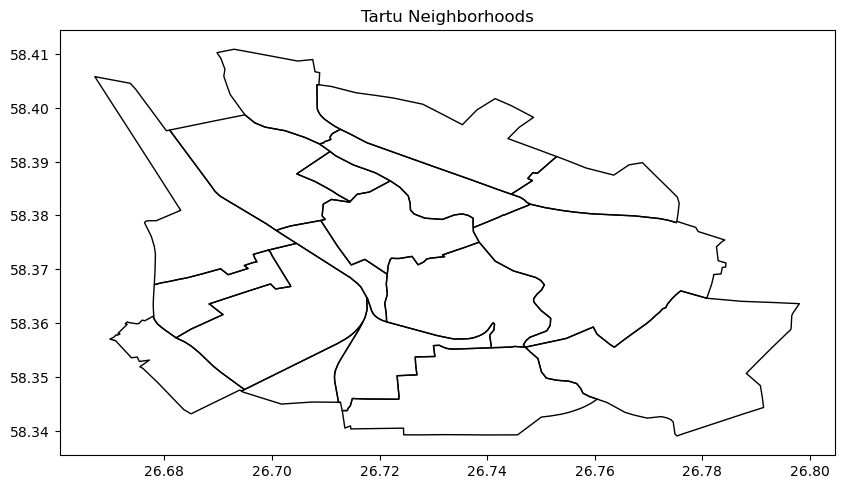

In [8]:
neighborhoods_gdf = gpd.read_file("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Tartu_linnaosad_wgs84.geojson")
neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:3301")

# removing larg eenighborhood not used
neighborhoods_gdf = neighborhoods_gdf[neighborhoods_gdf['NIMI'] != 'Endine Tähtvere vald']
neighborhoods_gdf.plot(edgecolor='black', facecolor='none', figsize=(10,10))
plt.title("Tartu Neighborhoods")
plt.show()

## Plotting high confidence estimates of fare evasion

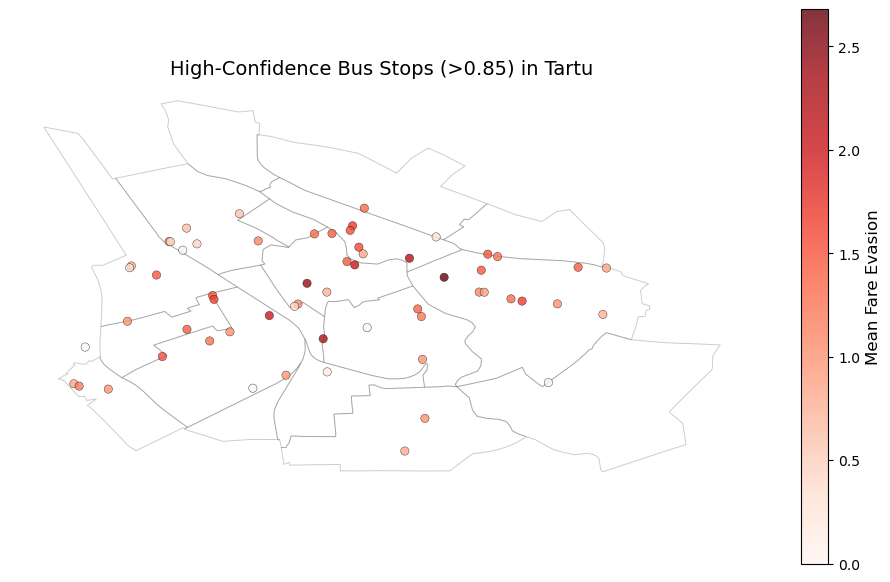

In [15]:
All_gdf = gpd.GeoDataFrame(
    All_merged,
    geometry=gpd.points_from_xy(All_merged["stop_lon"], All_merged["stop_lat"]),
    crs="EPSG:3301"
)

# Filter for high-confidence stops
All_high_conf = All_gdf[All_gdf["Confidence"] > 0.85]

# Then plot using All_high_conf 
fig, ax = plt.subplots(figsize=(12, 12))

# Plot neighbourhoods
neighborhoods_gdf.plot(
    ax=ax,
    edgecolor="black",
    facecolor="white",
    alpha=0.2,
    linewidth=0.7,
)

# Plot only high-confidence stops
scatter = ax.scatter(
    All_high_conf.geometry.x,
    All_high_conf.geometry.y,
    c=All_high_conf["mean"],           # colour = mean fare evasion
    cmap="Reds",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.3,
)

# Colourbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Mean Fare Evasion", fontsize=12)

# Formatting
plt.title("High-Confidence Bus Stops (>0.85) in Tartu", fontsize=14)
plt.axis("off")
plt.show()
